## Prepare ALOS-2 offset measurements

In [62]:
%matplotlib inline
import os
import glob
import datetime as dt
import numpy as np
import platform
from cartopy import crs as ccrs
from matplotlib import pyplot as plt
from mintpy.utils import ptime, readfile, writefile, isce_utils, utils as ut, plot as pp
from mintpy.cli import geocode, load_data, multilook, smallbaselineApp, view
plt.rcParams.update({'font.size': 12})

# platform
if platform.system() == 'Linux':
    proj_dir = os.path.expanduser('~/data/2024NotoPenEQ')
else:
    proj_dir = os.path.expanduser('~/data/archives/2024NotoPenEQ')

# dataset
ds_name = [
    'ALOS2_A127_20231206_20240103_RG',
    'ALOS2_A127_20231206_20240103_AZ',
    'ALOS2_D026_20230606_20240102_RG',
    'ALOS2_D026_20230606_20240102_AZ',
    'ALOS2_A121_20220926_20240101_RG',
    'ALOS2_A121_20220926_20240101_AZ',
][4]
redo = True

work_dir = os.path.join(proj_dir, ds_name[:-3], 'dense_offset')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# input files
date1, date2 = ptime.yymmdd(ds_name.split('_')[2:4])
off_file = f'{date1}-{date2}_denseoffset.off'
cov_file = f'{date1}-{date2}_denseoffset.cov'
snr_file = f'{date1}-{date2}_denseoffset.snr'

# output grid
S, N, W, E = 36.7, 37.6, 136.6, 137.45 # 36.57, 37.61, 136.57, 137.50  #

# output files
geom_file = os.path.join(work_dir, 'inputs/geometryRadar.h5')
rdr_file = os.path.join(work_dir, 'offRg.h5' if ds_name.endswith('RG') else 'offAz.h5')

Go to directory: /Users/yunjunz/data/archives/2024NotoPenEQ/ALOS2_A121_20220926_20240101/dense_offset


In [63]:
config = {
    'ALOS2_A127_20231206_20240103_RG': {'x_step':32, 'y_step':32, 'max_off':5, 'min_snr':5, 'max_std':0.5},
    'ALOS2_A127_20231206_20240103_AZ': {'x_step':32, 'y_step':32, 'max_off':6, 'min_snr':6, 'max_std':0.4},
    'ALOS2_D026_20230606_20240102_RG': {'x_step':32, 'y_step':32, 'max_off':5, 'min_snr':5, 'max_std':0.4},
    'ALOS2_D026_20230606_20240102_AZ': {'x_step':32, 'y_step':32, 'max_off':6, 'min_snr':6, 'max_std':0.4},
    'ALOS2_A121_20220926_20240101_RG': {'x_step':32, 'y_step':32, 'max_off':5, 'min_snr':5, 'max_std':0.4},
    'ALOS2_A121_20220926_20240101_AZ': {'x_step':32, 'y_step':32, 'max_off':6, 'min_snr':6, 'max_std':0.4},
}[ds_name]

In [64]:
# utils functions
def read_offset(meta, off_file, cov_file, snr_file):
    # calculate pixel_size (to convert offset unit from pixel to meters)
    obs_dir = 'range' if ds_name.endswith('RG') else 'azimuth'
    if obs_dir == 'range':
        pixel_size = float(meta['RANGE_PIXEL_SIZE']) / int(meta['RLOOKS'])
        print('Slant range pixel size: {:.2f} m'.format(pixel_size))
    else:
        Re, h_sat = float(meta['EARTH_RADIUS']), float(meta['HEIGHT'])
        pixel_size = float(meta['AZIMUTH_PIXEL_SIZE']) / int(meta['ALOOKS']) * Re / (Re + h_sat)
        print('Ground azimuth pixel size: {:.2f} m'.format(pixel_size))

    # read data / attribute
    off     = readfile.read(off_file, datasetName=f'{obs_dir}Offset')[0] * pixel_size
    off_std = readfile.read(cov_file, datasetName=f'{obs_dir}OffsetStd')[0] ** 0.5 * pixel_size
    off_snr = readfile.read(snr_file)[0]

    return off, off_std, off_snr


def mask_offset(off, off_std, off_snr, config, water_mask_file=None):
    # 1. ignore no-data-value
    no_data_value = readfile.get_no_data_value(off_file)
    off[off == no_data_value] = np.nan
    print(f'# of pixels after removing no-data-value ({no_data_value}): {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    # 2. ignore water body
    if water_mask_file is None:
        water_mask_files = [x for x in ['waterMask.rdr.mli', 'inputs/geometryRadar.h5', 'waterMask.rdr'] if os.path.exists(x)]
        if len(water_mask_files) > 0:
            water_mask_file = water_mask_files[0]
        else:
            raise FileNotFoundError('NO default water mask file found! Please specify one mannually.')
    water_mask = readfile.read(water_mask_file, datasetName='waterMask')[0]
    off[water_mask == 0] = np.nan
    off_std[water_mask == 0] = np.nan
    off_snr[water_mask == 0] = np.nan
    print(f'# of pixels after removing water body: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')
    off_raw = np.array(off, dtype=np.float32)

    # 3. remove pixels with abnormal offset
    off_std[np.isnan(off)] = np.nan
    off[np.abs(off) > config['max_off']] = np.nan
    print(f'# of pixels after removing offset > {config["max_off"]}: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    # 4. remove pixels with low offset SNR
    off[np.isnan(off_snr)] = np.nan
    flag = off_snr < config['min_snr']    # remove pixels with low SNR value
    flag[np.abs(off / off_std) > 3] = 0   # keep   pixels with high off / off_std
    flag[off_snr < 1] = 1                 # remove pixels with very low SNR value
    off[flag] = np.nan
    print(f'# of pixels after removing SNR < {config["min_snr"]}: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    # 5. remove pixels with high offset STD
    off_std[off_std > config['max_off']/2] = np.nan
    off[np.isnan(off_std)] = np.nan
    off[off_std > config['max_std']] = np.nan
    print(f'# of pixels after removing STD > {config["max_std"]}: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    return off, off_std, off_snr, off_raw


def count(data):
    """Count the number of valid pixels"""
    return np.sum(~np.isnan(data))


print('warm up utils functions.')

warm up utils functions.


### Prepare geometry files [on kunlun]

In [49]:
# multilook into the same grid as offset files
for fbase in ['hgt', 'lat', 'lon', 'los', 'wbd']:
    os.makedirs('./geom', exist_ok=True)
    out_file = f'./geom/{fbase}.rdr.mli'
    if not os.path.exists(out_file):
        multilook.main(f'{fbase}.rdr.vrt -x {config["x_step"]} -y {config["y_step"]} -o {out_file} --off-file {off_file}'.split())

# convert water body into water mask [for mintpy]
!generate_mask.py ./geom/wbd.rdr.mli --max 0.5 -o ./geom/waterMask.rdr.mli

input wbd file: ./geom/wbd.rdr.mli
read ./geom/wbd.rdr.mli
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value > 0.5
write file: ./geom/waterMask.rdr.mli
write file: ./geom/waterMask.rdr.mli.rsc
time used: 00 mins 0.0 secs.


Prepare metadata and load into HDF5/MintPy format.

In [50]:
# write geometry HDF5 file
config_str = f"""# vim: set filetype=cfg:
########## 1. Load Data (--load to exit after this step)
## load_data.py -H to check more details and example inputs.
mintpy.load.processor        = isce
##---------for ISCE only:
mintpy.load.metaFile         = ../{date2}.track.xml
mintpy.load.baselineDir      = None
##---------geometry datasets:
mintpy.load.demFile          = ./geom/hgt.rdr.mli
mintpy.load.lookupYFile      = ./geom/lat.rdr.mli
mintpy.load.lookupXFile      = ./geom/lon.rdr.mli
mintpy.load.incAngleFile     = ./geom/los.rdr.mli
mintpy.load.azAngleFile      = ./geom/los.rdr.mli
mintpy.load.waterMaskFile    = ./geom/waterMask.rdr.mli
"""
sname, oname = ds_name.split('_')[:2]
config_file = os.path.join(work_dir, f'{sname}_{oname}.txt')
print('write MintPy configuration to file: {}'.format(config_file))
with open(config_file, "w") as fid:
    fid.write(config_str)
smallbaselineApp.main(f'{config_file} -g'.split())
# write geometryRadar.h5
load_data.main(f'-t smallbaselineApp.cfg --geom'.split())

write MintPy configuration to file: /Users/yunjunz/data/archives/2024NotoPenEQ/ALOS2_A127_20231206_20240103/dense_offset/ALOS2_A127.txt
--------------------------------------------------
Project name: ALOS2_A127
Go to work directory: /Users/yunjunz/data/archives/2024NotoPenEQ/ALOS2_A127_20231206_20240103/dense_offset
read custom template file: /Users/yunjunz/data/archives/2024NotoPenEQ/ALOS2_A127_20231206_20240103/dense_offset/ALOS2_A127.txt
update default template based on input custom template
    mintpy.load.metaFile: ../RG.track.xml --> ../240103.track.xml
    mintpy.load.demFile: hgt.rdr.mli --> ./geom/hgt.rdr.mli
    mintpy.load.lookupYFile: lat.rdr.mli --> ./geom/lat.rdr.mli
    mintpy.load.lookupXFile: lon.rdr.mli --> ./geom/lon.rdr.mli
    mintpy.load.incAngleFile: los.rdr.mli --> ./geom/los.rdr.mli
    mintpy.load.azAngleFile: los.rdr.mli --> ./geom/los.rdr.mli
    mintpy.load.waterMaskFile: waterMask.rdr.mli --> ./geom/waterMask.rdr.mli
copy ALOS2_A127.txt       to inputs   

/Users/yunjunz/tools/MintPy/src/mintpy/load_data.py:703: UserWarning: prep_isce.py failed. Assuming its result exists and continue...
  warnings.warn('prep_isce.py failed. Assuming its result exists and continue...')


In [51]:
# grab the spatial resolution in meters
meta = readfile.read_attribute(geom_file)
inc_angle_c = float(meta['CENTER_INCIDENCE_ANGLE'])
ystep_m = ut.azimuth_ground_resolution(meta)
xstep_m = ut.range_ground_resolution(meta)
print(f'y/x step: {ystep_m:.1f} / {xstep_m:.1f} m')

# set to the nearest common integer value
step_m = 60 # m

# convert from meters to degrees
ystep_d = step_m / 108e3
xstep_d = step_m / (108e3 * np.cos(np.deg2rad(inc_angle_c)))
print(f'y/x step [from {step_m} m]: {ystep_d:.8f}, {xstep_d:.8f} deg')

y/x step: 59.5 / 67.3 m
y/x step [from 60 m]: 0.00055556, 0.00075873 deg


### Mask

+ convert the displacement unit from pixel to meters
+ mask the noisy pixels in the offset estimation based on SNR and STD

Ground azimuth pixel size: 2.22 m
# of pixels after removing no-data-value (0.0): 704158 out of 2002128 (35.2%)
# of pixels after removing water body: 689315 out of 2002128 (34.4%)
# of pixels after removing offset > 6: 680368 out of 2002128 (34.0%)
# of pixels after removing SNR < 6: 469499 out of 2002128 (23.4%)
# of pixels after removing STD > 0.4: 420437 out of 2002128 (21.0%)
create HDF5 file: /Users/yunjunz/data/archives/2024NotoPenEQ/ALOS2_D026_20230606_20240102/dense_offset/offAz.h5 with w mode


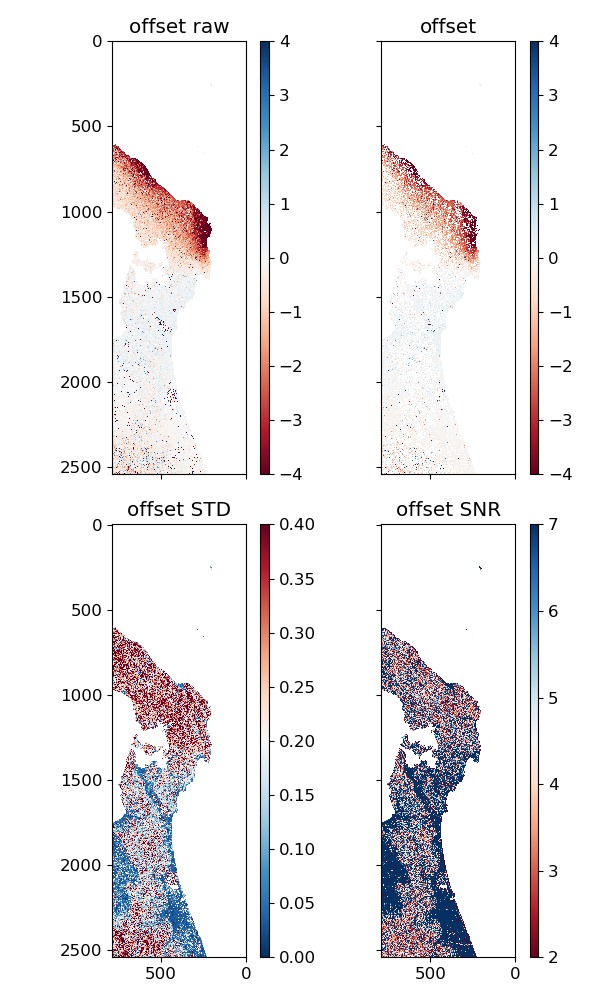

In [36]:
off, off_std, off_snr = read_offset(meta, off_file, cov_file, snr_file)
off, off_std, off_snr, off_raw = mask_offset(off, off_std, off_snr, config)

# write to one HDF5 files
meta['FILE_TYPE'] = 'displacement'
meta['ORBIT_DIRECTION'] = 'ASCENDING' if ds_name.split('_')[1].startswith('A') else 'DESCENDING'
if redo or not os.path.isfile(rdr_file):
    ds_dict      = {'displacement' : np.array(off, dtype=np.float32), 'displacementStd' : np.array(off_std, dtype=np.float32)}
    ds_unit_dict = {'displacement' : 'm', 'displacementStd' : 'm'}
    writefile.write(ds_dict, out_file=rdr_file, metadata=meta, ds_unit_dict=ds_unit_dict, compression='lzf', print_msg=False)

# plot
%matplotlib widget
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[6, 10], sharex=True, sharey=True)
for ax, data, [vmin, vmax], cmap, title in zip(axs.flatten(), [off_raw, off, off_std, off_snr], [[-4, 4], [-4, 4], [0, config['max_std']], [2, config['min_snr']+1]], ['RdBu', 'RdBu', 'RdBu_r', 'RdBu'], ['offset raw', 'offset', 'offset STD', 'offset SNR']):
    im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest'); fig.colorbar(im, ax=ax, aspect=50); pp.auto_flip_direction(meta, ax, print_msg=False); ax.set_title(title)
fig.tight_layout()
plt.show()

### Geocode

geocode.py /Users/yunjunz/data/archives/2024NotoPenEQ/ALOS2_A127_20231206_20240103/dense_offset/offAz.h5 --dset displacement -o /Users/yunjunz/data/archives/2024NotoPenEQ/ALOS2_A127_20231206_20240103/dense_offset/geo/offAz.geo -l /Users/yunjunz/data/archives/2024NotoPenEQ/ALOS2_A127_20231206_20240103/dense_offset/inputs/geometryRadar.h5 --fill nan --bbox 36.7 37.6 136.6 137.45 --lalo -0.0005555555555555556 0.0007587281956117515
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Users/yunjunz/data/archives/2024NotoPenEQ/ALOS2_A127_20231206_20240103/dense_offset/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.0005555555555555556, 0.0007587281956117515)
output area extent in (S, N, W, E) in degree: (36.7, 37.6, 136.6, 137.44977557908516)
output file row / column number: (1620, 1120)
[1/1] preparing geometry for dest_box: (0, 0, 1120, 1620) --> full src_box: (0, 0, 836, 2100)
--------------------------

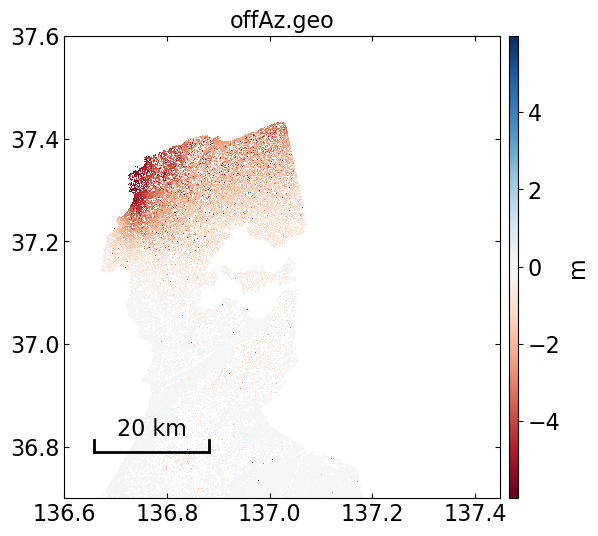

In [61]:
opt = f'-l {geom_file} --fill nan --bbox {S} {N} {W} {E} --lalo -{ystep_d} {xstep_d}'
fbase = os.path.join(os.path.dirname(rdr_file), 'geo', os.path.basename(rdr_file)[:-3])
io_files = [
    [rdr_file, '--dset displacement',    f'{fbase}.geo'],      # offset
    [rdr_file, '--dset displacementStd', f'{fbase}Std.geo'],   # offset STD
    ['geom/los.rdr.mli', '', './geo/los.geo'],                       # offset geometry
]
os.makedirs('./geo', exist_ok=True)
for ifile, dset, ofile in io_files:
    if redo or not os.path.isfile(ofile):
        cmd = f'{ifile} {dset} -o {ofile} {opt}'
        print(f'geocode.py {cmd}')
        geocode.main(cmd.split())
        meta['BANDS'] = 1
        writefile.write_isce_xml(meta, fname=ofile)

# plot
%matplotlib inline
view.main(f'{fbase}.geo -c RdBu --noverbose'.split())

### Final plot

run view.py in MintPy version 1.5.3.post11, date 2024-01-20
input file is isce displacement file: /Users/yunjunz/data/archives/2024NotoPenEQ/ALOS2_A127_20231206_20240103/dense_offset/offAz.geo in float32 format
file size in y/x: (1620, 1120)
num of datasets in file offAz.geo: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 1120, 1620)
subset coverage in y/x: (0, 0, 1120, 1620)
data   coverage in lat/lon: (136.6, 37.6, 137.44977557908516, 36.699999999999996)
subset coverage in lat/lon: (136.6, 37.6, 137.44977557908516, 36.699999999999996)
------------------------------------------------------------------------
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: ALOS2_A127_20231206_20240103_AZ
figure size : [7.1, 6.0]
reading data ...
data    range: [-5.995578, 5.9665437] m
display range: [-3.0, 3.0] m
reading DEM: elevation.dem ...
display data in transparency: 0.8
plot in geo-coordinate
plotting DEM background ...
sh

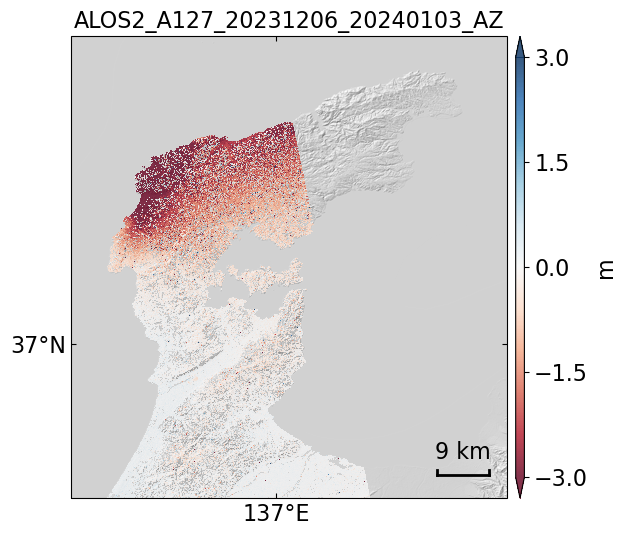

In [59]:
%matplotlib inline
dis_file = os.path.join('geo', f'{rdr_file[:-3]}.geo') # if ds_name.endswith('AZ') else f'{fbase}_ERA5_SET.geo'
dem_file = os.path.join(proj_dir, 'DEM/elevation.dem')
out_file = os.path.join(proj_dir, f'notebooks/pic/{ds_name}.png')
cmd = f'{dis_file} --dem {dem_file} --dem-nocontour --shade-exag 0.05 '
cmd += f'-c RdBu -v -3 3 --lalo-label --lalo-step 1 --cbar-nbins 5 --scalebar 0.12 0.90 0.05 --title {ds_name} '
cmd += f'-o {out_file} '
view.main(cmd.split())